In [192]:
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#Run the below piece of code for the first time
#nltk.download('stopwords')

In [193]:
dialogs_data = pd.read_csv("dialog_lines.csv",encoding = "UTF8")
dialogs_data.head()

,racist/not_racist,dialog_line
0,not_racist,\n\n\n \n\n\n\n CONTINUED\n\...
1,not_racist,\n\n\n \n\n\n\n CONTINUED\n\...
2,not_racist,NIGHT\n\n\n\n\n \n\n\n\n \n...
3,not_racist,\n\n\n\n \n\n\n\n \n\n\n\n ...
4,not_racist,Im going inside\n\n\n \n\n\n\n ...


In [194]:
#dialogs_data.groupby('racist/not_racist').describe()

nrd = dialogs_data[dialogs_data['racist/not_racist'] == 'not_racist'].sample(877)
rd = dialogs_data[dialogs_data['racist/not_racist'] == 'racist']

dialogs_data = pd.concat([nrd, rd])
dialogs_data.groupby('racist/not_racist').describe()


dialog_line                             
                        count unique              top freq
racist/not_racist                                         
not_racist                877    823     \n              9
racist                   1377   1371  BEMBRY \n\n\t\t    4

In [195]:
dialogs_data_copy = dialogs_data['dialog_line'].copy()


In [196]:
def text_preprocess(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [197]:
dialogs_data_copy = dialogs_data_copy.apply(text_preprocess)

In [198]:
dialogs_data_copy

36308    Sequence omitted original script EXT STATION P...
1662                                         Hes kid Doris
13355                                         Uhhuh MARLIN
37684    FORD Jesus called little child unto set midst ...
28154           know Im JANE AARON kind relationship Devil
                               ...                        
39313    remove lids finelycrafted false bottoms reveal...
39315    minister steps welcomes congregation includes ...
39316    laundry truck comes past guard gate leaves bas...
39337    Several black white undercover cars approach s...
39356    Frank moves gallery Richie sees full gangsters...
Name: dialog_line, Length: 2254, dtype: object

In [199]:
vectorizer = TfidfVectorizer()

In [200]:
dialogs_mat = vectorizer.fit_transform(dialogs_data_copy)
dialogs_mat

<2254x7870 sparse matrix of type '<class 'numpy.float64'>'
	with 30104 stored elements in Compressed Sparse Row format>

In [201]:
dialogs_train, dialogs_test, r_nr_train, r_nr_test = train_test_split(dialogs_mat, 
                                                        dialogs_data['racist/not_racist'], test_size=0.3, random_state=20)


In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

racist_model = LogisticRegression(solver='liblinear', penalty='l1')
racist_model.fit(dialogs_train, r_nr_train)
pred = racist_model.predict(dialogs_test)
accuracy_score(r_nr_test,pred)
print("Accuracy:",metrics.accuracy_score(r_nr_test,pred))


Accuracy: 0.912850812407681


## Analizando el modelo

In [203]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(r_nr_test, pred)
cnf_matrix

array([[275,   9],
       [ 50, 343]])

In [204]:

r_nr_test = np.array(list(map(lambda s: 0 if s == "not_racist" else 1, r_nr_test)))

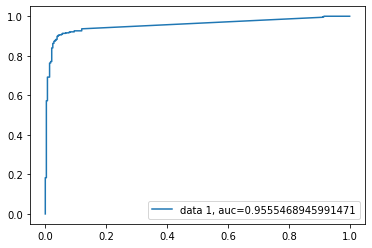

In [205]:
y_pred_proba = racist_model.predict_proba(dialogs_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(r_nr_test,  y_pred_proba)
auc = metrics.roc_auc_score(r_nr_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [206]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

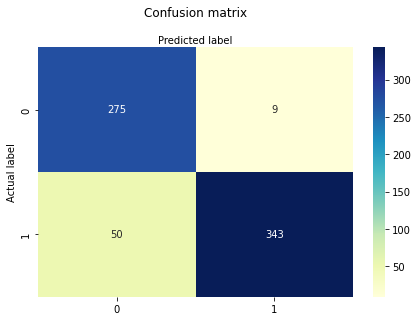

In [207]:
class_names=["not_racist","racist"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')